<a href="https://colab.research.google.com/github/juhumkwon/-S3I-/blob/main/CL_08_02_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.3255 - val_loss: 0.2631
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2632 - val_loss: 0.2631
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2633 - val_loss: 0.2627
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2630 - val_loss: 0.2627
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2629 - val_loss: 0.2631
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2633 - val_loss: 0.2642
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2632 - val_loss: 0.2627
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2627 - val_loss: 0.2628
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.2631 - val_loss: 0.2627
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2629 - val_loss: 0.2626
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.26

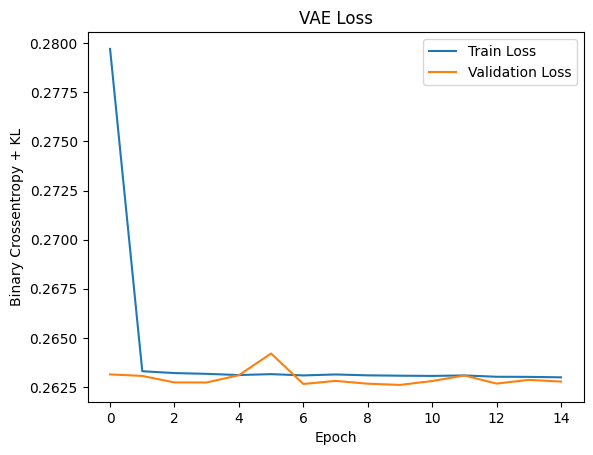

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


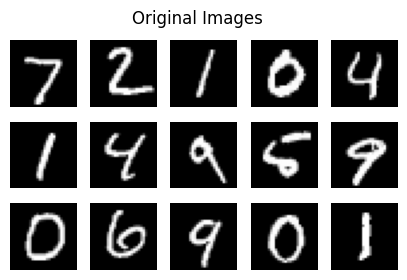

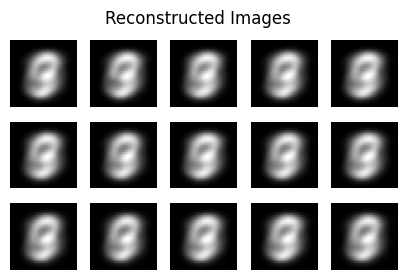

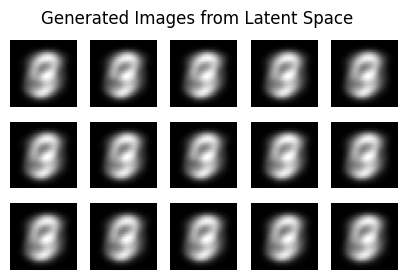

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ 데이터 로드 및 전처리
# ===============================
(x_train, _), (x_valid, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_valid = x_valid.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_valid = np.reshape(x_valid, (-1, 28, 28, 1))

# 하이퍼파라미터
latent_dim = 2  # 잠재공간 차원
learning_rate = 0.001
batch_size = 128
epochs = 100

# ===============================
# 2️⃣ 인코더 정의
# ===============================
def build_encoder():
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# ===============================
# 3️⃣ 샘플링 레이어 정의 (Reparameterization Trick)
# ===============================
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ===============================
# 4️⃣ 디코더 정의
# ===============================
def build_decoder():
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu")(decoder_inputs)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")

# ===============================
# 5️⃣ VAE 모델 정의
# ===============================
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)

        # KL Divergence 손실 추가
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        self.add_loss(kl_loss)
        return reconstructed

# ===============================
# 6️⃣ 인스턴스 생성 및 컴파일
# ===============================
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)

vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy"
)

# ===============================
# 7️⃣ 콜백 (EarlyStopping)
# ===============================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# ===============================
# 8️⃣ 학습
# ===============================
history = vae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid, x_valid),
    callbacks=[early_stop],
    verbose=1
)

# ===============================
# 9️⃣ 학습 결과 시각화
# ===============================
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("VAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy + KL")
plt.legend()
plt.show()

# ===============================
# 🔟 이미지 복원 및 생성
# ===============================
def plot_images(images, n_rows, n_cols, title=""):
    plt.figure(figsize=(n_cols, n_rows))
    plt.suptitle(title)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# ✅ 복원 이미지 확인
decoded_imgs = vae.predict(x_valid[:15])
plot_images(x_valid[:15], 3, 5, "Original Images")
plot_images(decoded_imgs, 3, 5, "Reconstructed Images")

# ✅ 잠재공간에서 무작위 생성
n_images = 15
codings = tf.random.normal(shape=[n_images, latent_dim])
generated_images = vae.decoder(codings).numpy()
plot_images(generated_images, 3, 5, "Generated Images from Latent Space")
